In [3]:
library(qvalue)
library(dplyr)
library(ggplot2)
library(cowplot)

In [2]:
# common genes, i.e. genes tested for all aggregations
df_common_genes = read.csv("/hps/nobackup/stegle/users/acuomo/all_scripts/sc_eqtl/common_genes_across_all_aggregation_methods_and_bulk.csv")
common_genes = as.character(df_common_genes$gene)
length(common_genes)

[1] 12720

In [4]:
# highly variable genes (top 50% CV)
Giordanos_selection = "/hps/nobackup/stegle/users/galvari/data/iPSCs/singleCell/metadata/ensembl_gene/Ensembl_75_Gene_CV_quant5.txt"
G_file = read.csv(Giordanos_selection, sep = "\t")
nrow(G_file)
head(G_file,2)

[1] 21592

,gene,mean,std,CV,quartile_cv
2,ENSG00000227232,3.1805905,3.6232403,1.139172,2
3,ENSG00000243485,0.2003178,0.8649483,4.317881,3


In [5]:
#### load bulk results
##### a-bulk (all results)
bulk_folder = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/Bulk/BulkTotal_PCA20/"
res_all = read.csv(paste0(bulk_folder,"qtl_results_all.txt"), sep = "\t")

In [6]:
# a-bulk (lead SNP only, to get significance threshold at FDR<10%)
leads_all = read.csv(paste0(bulk_folder,"top_qtl_results_all.txt"), sep = "\t")
leads_all = leads_all[leads_all$feature_id %in% common_genes,]
leads_all$q_value = qvalue(leads_all$empirical_feature_p_value)$qvalues
max_qval = max(leads_all[leads_all$q_value < 0.1,'q_value'])
emp_pv_star_all = max(leads_all[leads_all$q_value==max_qval,"empirical_feature_p_value"])
emp_pv_star_all

[1] 0.4923506

In [7]:
##### m-bulk (all results)
bulk_matched_folder = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/Bulk/BulkDay0Healthy_PCA20_88_206/"
res = read.csv(paste0(bulk_matched_folder,"qtl_results_all.txt"), sep = "\t")

In [8]:
# m-bulk (lead SNP only, to get significance threshold at FDR<10%)
leads = read.csv(paste0(bulk_matched_folder,"top_qtl_results_all.txt"), sep = "\t")
leads = leads[leads$feature_id %in% common_genes,]
leads$q_value = qvalue(leads$empirical_feature_p_value)$qvalues
max_qval = max(leads[leads$q_value < 0.1,'q_value'])
emp_pv_star_matched = max(leads[leads$q_value==max_qval,"empirical_feature_p_value"])
emp_pv_star_matched

[1] 0.05473347

In [9]:
### dr-mean
dir0 = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/SingleCell/PseudoBulk/mean/Run_Output_PCA20_88_log_TPM_scater_libsize_206/"
df0 = read.csv(paste0(dir0,"top_qtl_results_all.txt"), sep="\t")
df0 = df0[df0$feature_id %in% common_genes,]
head(df0,2)

snp_id,p_value,beta,beta_se,empirical_feature_p_value,feature_chromosome,feature_start,feature_end,n_samples,n_e_samples,alpha_param,beta_param,snp_chromosome,snp_position,assessed_allele,call_rate,maf,hwe_p,feature_id
19_45850366_C_T,0.013371986,0.1850959,0.07482535,0.3493466,19,45582546,45808541,152,87,0.5727331,80.55800,19,45850366,T,1,0.2758621,0.7928074,ENSG00000007047
19_45615556_A_G,0.008822012,-0.2052828,0.07838584,0.7220340,19,45666186,45681495,152,87,0.4032916,55.55858,19,45615556,G,1,0.1666667,0.6965823,ENSG00000007255


In [10]:
# first consider eQTL tested in all sets
eqtls_dr = unique(paste0(df0$feature_id,"-",df0$snp_id))
eqtls_m = unique(paste0(res$feature_id,"-",res$snp_id))
eqtls_a = unique(paste0(res_all$feature_id,"-",res_all$snp_id))

In [11]:
eqtls0 = eqtls_dr[eqtls_dr %in% eqtls_m]
common_eqtls = eqtls0[eqtls0 %in% eqtls_a]

In [12]:
length(common_eqtls)

[1] 12610

In [13]:
# then assess replication in either bulk sets

In [14]:
df0$q_value = qvalue(df0$empirical_feature_p_value)$qvalues
df1 = df0[df0$q_value < 0.05,]
df1 = df1[-which(duplicated(df1$feature_id)),]
sc_eqtls = unique(paste0(df1$feature_id,"-",df1$snp_id))
sc_eqtls = sc_eqtls[sc_eqtls %in% common_eqtls]
length(sc_eqtls)

[1] 1828

In [15]:
# single-cell eQTL (dr-mean) replicated in m-bulk
df2 = inner_join(df1, res, by = c("snp_id","feature_id"), suffix = c(".sc",".bulk"))
df3 = df2[(df2$empirical_feature_p_value.bulk < emp_pv_star_matched & 
         (df2$beta.sc*df2$beta.bulk)>0),]
sc_eqtls_m = unique(paste0(df3$feature_id,"-",df3$snp_id))

In [16]:
length(sc_eqtls_m)

[1] 887

In [17]:
# single-cell eQTL (dr-mean) replicated in a-bulk
df4 = inner_join(df1, res_all, by = c("snp_id","feature_id"), suffix = c(".sc",".bulk"))
df5 = df4[(df4$empirical_feature_p_value.bulk < emp_pv_star_all & 
         (df4$beta.sc*df4$beta.bulk)>0),]
sc_eqtls_a = unique(paste0(df5$feature_id,"-",df5$snp_id))

In [18]:
length(sc_eqtls_a)

[1] 1367

In [19]:
# next, define three catagories:
# 1. single-cell eQTL replicated in both m-bulk and a-bulk
# 2. single-cell eQTL replicated in a-bulk but NOT m-bulk
# 3. single-cell eQTL not replicated in either

In [20]:
eqtls1 = sc_eqtls_m[sc_eqtls_m %in%  sc_eqtls_a]
eqtls2 = sc_eqtls_a[!(sc_eqtls_a %in%  sc_eqtls_m)]
eqtls3 = sc_eqtls[!(sc_eqtls %in% eqtls1)]

In [21]:
length(eqtls1)
length(eqtls2)
length(eqtls3)

[1] 885

[1] 482

[1] 943

In [22]:
df1$eqtl = paste0(df1$feature_id,"-",df1$snp_id)
df_to_plot = df1[df1$eqtl %in% sc_eqtls,c("feature_id","snp_id","eqtl","beta")]
nrow(df_to_plot)
head(df_to_plot,2)

[1] 1828

,feature_id,snp_id,eqtl,beta
4,ENSG00000012061,19_45938020_T_A,ENSG00000012061-19_45938020_T_A,0.3405447
14,ENSG00000104884,19_45870658_C_T,ENSG00000104884-19_45870658_C_T,-0.2699475


In [23]:
# get mean, variance (and CV2) for the genes
# consider effect size in the a) single-cell run, b) bulk run (probably a-bulk)

In [24]:
G_file$feature_id = G_file$gene
df_to_plot2 = inner_join(df_to_plot, G_file, by = "feature_id")
nrow(df_to_plot2)
head(df_to_plot2,2)

[1] 1827

feature_id,snp_id,eqtl,beta,gene,mean,std,CV,quartile_cv
ENSG00000012061,19_45938020_T_A,ENSG00000012061-19_45938020_T_A,0.3405447,ENSG00000012061,27.80471,24.66718,0.8871581,1
ENSG00000104884,19_45870658_C_T,ENSG00000104884-19_45870658_C_T,-0.2699475,ENSG00000104884,21.82815,21.53558,0.9865969,1


In [25]:
df_to_plot2$m_bulk = df_to_plot2$eqtl %in% sc_eqtls_m
df_to_plot2$a_bulk = df_to_plot2$eqtl %in% sc_eqtls_a
df_to_plot2$abs_sc_beta = abs(df_to_plot2$beta)
head(df_to_plot2,2)

feature_id,snp_id,eqtl,beta,gene,mean,std,CV,quartile_cv,m_bulk,a_bulk,abs_sc_beta
ENSG00000012061,19_45938020_T_A,ENSG00000012061-19_45938020_T_A,0.3405447,ENSG00000012061,27.80471,24.66718,0.8871581,1,TRUE,TRUE,0.3405447
ENSG00000104884,19_45870658_C_T,ENSG00000104884-19_45870658_C_T,-0.2699475,ENSG00000104884,21.82815,21.53558,0.9865969,1,TRUE,TRUE,0.2699475


In [26]:
df_to_plot2[df_to_plot2$m_bulk & df_to_plot2$a_bulk,"category"] = "both"
df_to_plot2[df_to_plot2$m_bulk & !df_to_plot2$a_bulk,"category"] = "only_m_bulk"
df_to_plot2[!df_to_plot2$m_bulk & df_to_plot2$a_bulk,"category"] = "only_a_bulk"
df_to_plot2[!df_to_plot2$m_bulk & !df_to_plot2$a_bulk,"category"] = "neither"
tail(df_to_plot2)

,feature_id,snp_id,eqtl,beta,gene,mean,std,CV,quartile_cv,m_bulk,a_bulk,abs_sc_beta,category
1822,ENSG00000172954,2_30861869_G_C,ENSG00000172954-2_30861869_G_C,-0.4701805,ENSG00000172954,18.782338,18.456819,0.9826688,1,FALSE,FALSE,0.4701805,neither
1823,ENSG00000160948,8_145638811_C_A,ENSG00000160948-8_145638811_C_A,0.8094079,ENSG00000160948,17.701708,16.475236,0.9307145,1,TRUE,TRUE,0.8094079,both
1824,ENSG00000170619,8_146177719_T_C,ENSG00000170619-8_146177719_T_C,0.2404412,ENSG00000170619,22.311135,20.755598,0.9302798,1,FALSE,FALSE,0.2404412,neither
1825,ENSG00000187954,8_145688482_C_T,ENSG00000187954-8_145688482_C_T,0.3977094,ENSG00000187954,11.889580,14.002279,1.1776933,2,FALSE,TRUE,0.3977094,only_a_bulk
1826,ENSG00000196150,8_146128340_A_G,ENSG00000196150-8_146128340_A_G,0.3595358,ENSG00000196150,10.916589,15.066666,1.3801624,2,FALSE,FALSE,0.3595358,neither
1827,ENSG00000164124,4_159150467_G_A,ENSG00000164124-4_159150467_G_A,-0.4864096,ENSG00000164124,2.192241,6.017859,2.7450712,3,FALSE,TRUE,0.4864096,only_a_bulk


In [27]:
df_to_plot2 %>% group_by(category) %>% summarise(eGenes = n())

category,eGenes
both,884
neither,460
only_a_bulk,482
only_m_bulk,1


In [28]:
df_to_plot2$category = factor(df_to_plot2$category, levels = c("both", "only_m_bulk","only_a_bulk","neither"))

In [29]:
df_to_plot2 = df_to_plot2[df_to_plot2$category %in% c("both", "only_a_bulk","neither"),]

In [30]:
options(repr.plot.width = 6, repr.plot.height = 8)
p1 = df_to_plot2 %>% group_by(category) %>% summarise(eGenes = n()) %>%
    ggplot(aes(x = category, y = eGenes, fill = category)) + geom_bar(stat="identity") + theme_classic()
p2 = ggplot(df_to_plot2, aes(x = category, y = log2(mean+1), fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()
p3 = ggplot(df_to_plot2, aes(x = category, y = log2(std**2+1),fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()
p4 = ggplot(df_to_plot2, aes(x = category, y = abs_sc_beta, fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()

# plot_grid(p1,p2,p3,p4,ncol=1) 

In [31]:
### bulk stats
mb_stats_filename = "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_eqtl/stats_HipSci_passQc_87.txt"
ab_stats_filename = "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_eqtl/stats_HipSci_passQc.txt"

In [32]:
mb_stats = read.csv(mb_stats_filename, sep = "\t", row.names = 1)
head(mb_stats,2)

,FractionOfZero,MeanTPM_All,MeanTPM_nonZero,VarTPM_All,VarTPM_nonZero
ENSG00000223972,0.1685393,7.856757e-02,9.449342e-02,2.247140e-02,2.556331e-02
ENSG00000227232,0.0000000,2.631843e+41,2.631843e+41,6.155435e+84,6.155435e+84


In [33]:
ab_stats = read.csv(ab_stats_filename, sep = "\t", row.names = 1)
head(ab_stats,2)

,FractionOfZero,MeanTPM_All,MeanTPM_nonZero,VarTPM_All,VarTPM_nonZero
ENSG00000223972,0.1919315,1.122548e-01,1.389175e-01,3.367321e-01,4.131240e-01
ENSG00000227232,0.0000000,2.146480e+126,2.146480e+126,3.768833e+255,3.768833e+255


In [34]:
mb_stats$feature_id = rownames(mb_stats)
ab_stats$feature_id = rownames(ab_stats)

In [35]:
df_to_plot3 = inner_join(df_to_plot2, mb_stats)
head(df_to_plot3,2)

Joining, by = "feature_id"


feature_id,snp_id,eqtl,beta,gene,mean,std,CV,quartile_cv,m_bulk,a_bulk,abs_sc_beta,category,FractionOfZero,MeanTPM_All,MeanTPM_nonZero,VarTPM_All,VarTPM_nonZero
ENSG00000012061,19_45938020_T_A,ENSG00000012061-19_45938020_T_A,0.3405447,ENSG00000012061,27.80471,24.66718,0.8871581,1,TRUE,TRUE,0.3405447,both,0,1.24816e+93,1.24816e+93,1.384978e+188,1.384978e+188
ENSG00000104884,19_45870658_C_T,ENSG00000104884-19_45870658_C_T,-0.2699475,ENSG00000104884,21.82815,21.53558,0.9865969,1,TRUE,TRUE,0.2699475,both,0,1.74101e+204,1.74101e+204,Inf,Inf


In [36]:
# hist(df_to_plot3$FractionOfZero)
# hist(log2(df_to_plot3$MeanTPM_All+1))

In [37]:
mean(df_to_plot3[df_to_plot3$category == "both","FractionOfZero"])
mean(df_to_plot3[df_to_plot3$category == "neither","FractionOfZero"])
mean(df_to_plot3[df_to_plot3$category == "only_a_bulk","FractionOfZero"])

[1] 0.00284712

[1] 0.02020029

[1] 0.009068022

In [38]:
options(repr.plot.width = 6, repr.plot.height = 8)
p5 = ggplot(df_to_plot3, aes(x = category, y = FractionOfZero, fill= category)) + geom_violin() + theme_classic() #+ ylim(c(0,0.025)) #+ geom_boxplot(width=0.2)
p6 = ggplot(df_to_plot3, aes(x = category, y = log2(MeanTPM_nonZero+1), fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()
p7 = ggplot(df_to_plot3, aes(x = category, y = log2(VarTPM_nonZero+1), fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()

# plot_grid(p1,p2,p3,p4,ncol=1)
# plot_grid(p1,p5,p6,p7,ncol=1)
# p6

In [39]:
nrow(df_to_plot3)
df_to_plot4 = inner_join(df_to_plot3, res, by = c("snp_id","feature_id"), suffix = c("sc","bulk"))
nrow(df_to_plot4)

[1] 1826

[1] 1833

In [40]:
p8 = ggplot(df_to_plot4, aes(x = category, y = abs(betabulk), fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()
# plot_grid(p1,p6,p7,p8,ncol=1)

In [41]:
df_to_plot5 = inner_join(df_to_plot2, ab_stats)
df_to_plot6 = inner_join(df_to_plot5, res, by = c("snp_id","feature_id"), suffix = c("sc","bulk"))

Joining, by = "feature_id"


In [42]:
p9 = ggplot(df_to_plot5, aes(x = category, y = FractionOfZero, fill= category)) + geom_violin() + theme_classic() #+ ylim(c(0,0.025)) #+ geom_boxplot(width=0.2)
p10 = ggplot(df_to_plot5, aes(x = category, y = log2(MeanTPM_nonZero+1), fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()
p11 = ggplot(df_to_plot5, aes(x = category, y = log2(VarTPM_nonZero+1), fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()
p12 = ggplot(df_to_plot6, aes(x = category, y = abs(betabulk), fill= category)) + geom_violin() + geom_boxplot(width=0.2) + theme_classic()
# plot_grid(p1,p9,p10,p11,p12,ncol=1)

In [43]:
type.col <- c(both = "#336b87", only_a_bulk = "#f98866", only_m_bulk = "grey", neither="#66a5ad")

Warning message:
“Removed 587 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 587 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 974 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 974 rows containing non-finite values (stat_boxplot).”

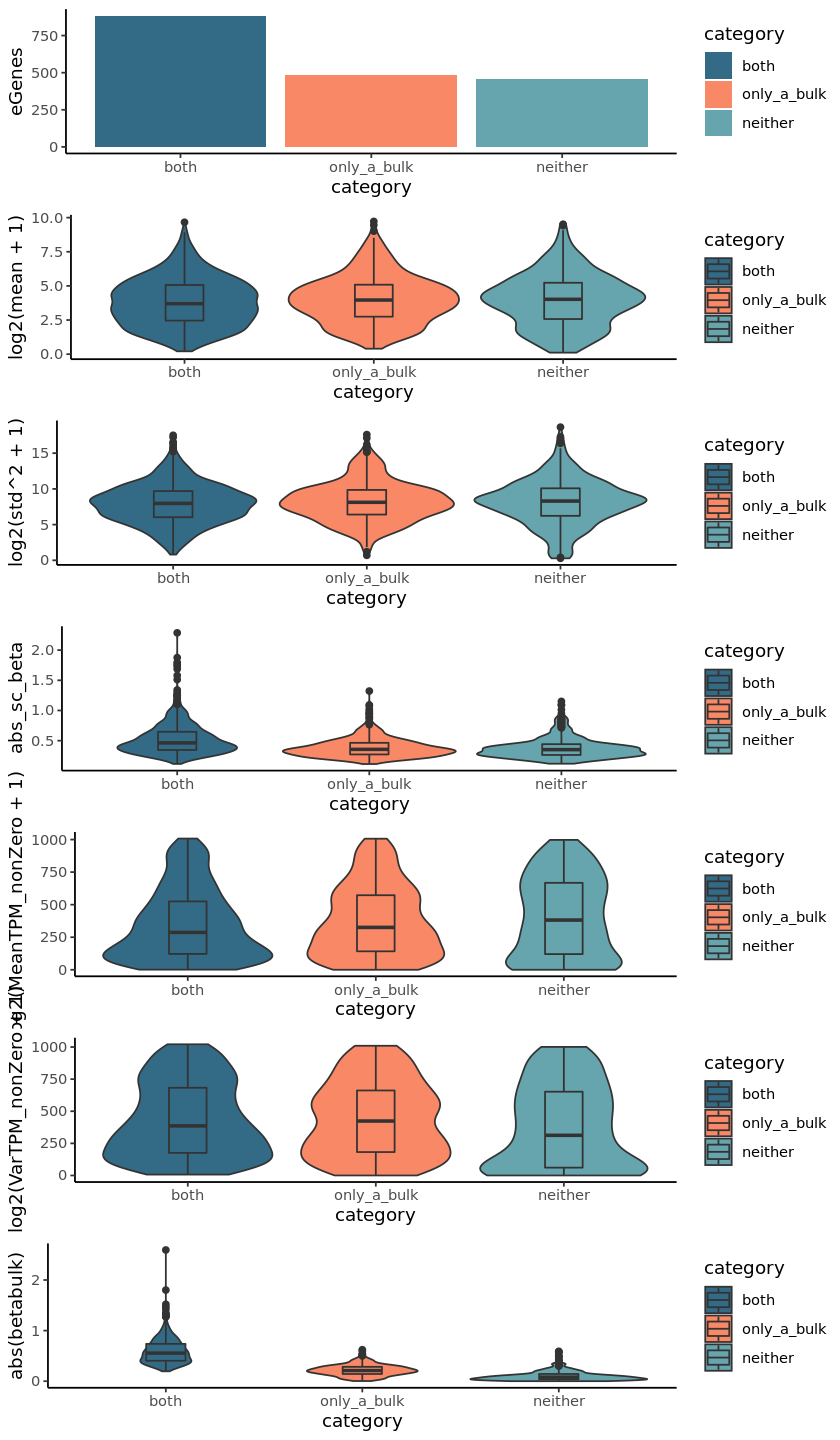

In [44]:
options(repr.plot.width = 7, repr.plot.height = 12)
plot_grid(p1+scale_fill_manual(values = type.col),
          p2+scale_fill_manual(values = type.col),
          p3+scale_fill_manual(values = type.col),
          p4+scale_fill_manual(values = type.col),
          p10+scale_fill_manual(values = type.col),
          p11+scale_fill_manual(values = type.col),
          p12+scale_fill_manual(values = type.col), ncol=1)

In [45]:
fig_dir = "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_eqtl/figures/"

In [46]:
pdf(paste0(fig_dir,"eqtl_properties_sc_bulk.pdf"), width=7, height=12)
plot_grid(p1+scale_fill_manual(values = type.col),
          p2+scale_fill_manual(values = type.col),
          p3+scale_fill_manual(values = type.col),
          p4+scale_fill_manual(values = type.col),
          p10+scale_fill_manual(values = type.col),
          p11+scale_fill_manual(values = type.col),
          p12+scale_fill_manual(values = type.col), ncol=1)
dev.off()

Warning message:
“Removed 587 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 587 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 974 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 974 rows containing non-finite values (stat_boxplot).”

png 
  2